In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import emcee

from question_3 import UniformPrior, Likelihood, LogProb, AutocorrelationTime, Template
from data_loader import Data

In [2]:
filepath = 'simple-cw-master/'
filename = 'cw_' + 'example' + '.csv'

data = Data(filepath + filename)

In [21]:
ndim = 2
nwalkers = 4
steps = 1000
# (epsilon, fdot): true value for epsilon is 1e-6, true value for fdot is 1e-4
# prior_lower_bounds = (0.9e-6, 0.9e-4)
# prior_upper_bounds = (1.1e-6, 1.1e-4)

prior_lower_bounds = (0, 0)
prior_upper_bounds = (1e-4, 1e-3)

In [22]:
prior = UniformPrior(lower_bounds=prior_lower_bounds, upper_bounds=prior_upper_bounds) # initialize the prior, which is uniform (1 in allowed region, 0 otherwise)
likelihood = Likelihood() # initialize likelihood function
log_prob = LogProb(likelihood=likelihood, prior=prior) # pass likelihood function and prior into log_probability, where log_prob = log_likelihood + log_prior

In [23]:
p0 = np.random.uniform(size=(nwalkers, ndim), low=prior_lower_bounds, high=prior_upper_bounds) # random initial guesses, using the same bounds as the prior

In [24]:
dtype=[('log_like', float)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[data.times, data.signal, data.f_rot0], blobs_dtype=dtype) # initialize MCMC sampler

In [25]:
sampler.run_mcmc(p0, steps, progress=True) # run MCMC sampler

D:\OneDrive - University of Toronto\CITA\CITA_mini_project\question_3.py:72: RuntimeWarning: divide by zero encountered in log
  log_like = np.log(self.likelihood(signal, model))
  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\Users\Kyle\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
D:\OneDrive - University of Toronto\CITA\CITA_mini_project\question_3.py:73: RuntimeWarning: divide by zero encountered in log
  log_prior = np.log(self.prior((self.epsilon_guess, self.df_dt_guess)))
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 222.32it/s]


State([[6.65870172e-05 6.77624067e-04]
 [1.40919565e-05 9.42529577e-05]
 [4.10638762e-06 4.32831068e-04]
 [1.12821592e-05 1.09955325e-04]], log_prob=[        -inf  -9.27695614 -91.03500811  -8.91029808], blobs=[(        -inf,) ( -9.27695614,) (-91.03500811,) ( -8.91029808,)], random_state=('MT19937', array([3521039651,  580787762, 2902539680,  648330258, 1061301743,
       1480747288, 2702193125,  170721230, 2798395965, 1156029975,
       3195597547, 4293033866,  353805353, 4277873048, 1410945942,
       3695097516,  425893032,  623536658,  270259294, 1516377008,
       2611647788,  414384446, 2733734866,  214553824,  987557469,
       4247919943, 1635889661, 1591918359, 2858764593, 2007747135,
       1062546307, 4092273744, 2305657234, 3022751812, 2926499088,
       4125803638, 1433472222, 3657540040, 3646689013, 3370177846,
       4155149046, 4210895107, 1113561799, 3608221007, 4067102717,
        344848108, 1314364419,  919281511, 4239815316, 1790413489,
       4020878099, 239934229

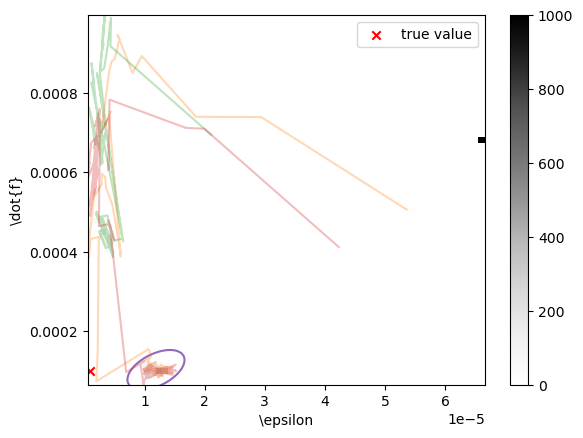

In [26]:
flat_samples = sampler.get_chain(flat=True) # get flattened samples for plotting histograms
samples = sampler.get_chain() # get samples for plotting individual chains

epsilon_points = flat_samples[:, 0]
df_dt_points = flat_samples[:, 1]

epsilon_walk = samples[:, :, 0]
df_dt_walk = samples[:, :, 1]

plt.figure() # plot histogram, contour plot, and chains all overlaid, with true value incidated

plt.plot(epsilon_walk, df_dt_walk, alpha=0.3)
sns.kdeplot(x=epsilon_points, y=df_dt_points, levels=[0.9])
plt.hist2d(x=epsilon_points, y=df_dt_points, bins=64, cmap='Greys')
plt.colorbar()

plt.scatter([1e-6], [1e-4], label='true value', color='red', marker='x')
plt.legend()

plt.xlabel(r'\epsilon')
plt.ylabel(r'\dot{f}')

plt.show()

In [27]:
samples = np.swapaxes(samples, 0, 1) # gives chains of parameter vectors, to incorporate Speagle definition of autocorrelation time

for i, chain in enumerate(samples):
    autocorrelation_time = AutocorrelationTime(chain)
    print('autocorrelation time for chain %i:' %i, autocorrelation_time.tau)

1 2


ValueError: could not broadcast input array from shape (1000,2) into shape (1,)

chain 0 (epsilon, fdot): 6.658701715435223e-05 0.0006776240666367041
chain 1 (epsilon, fdot): 1.4091956525171357e-05 9.425295771116934e-05
chain 2 (epsilon, fdot): 4.106387623888745e-06 0.0004328310678378098
chain 3 (epsilon, fdot): 1.128215921420481e-05 0.00010995532506853455


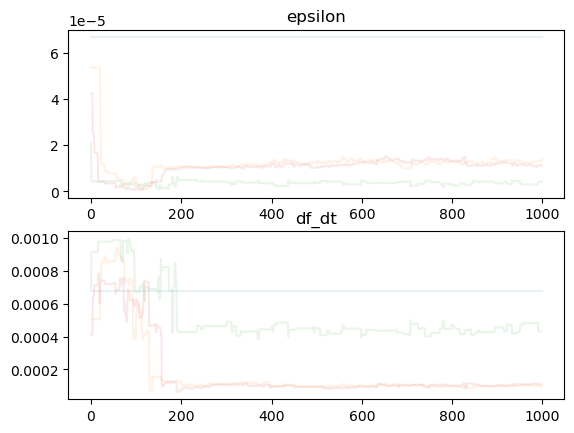

In [30]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1) # trace plots for each parameter

for i, chain in enumerate(samples):
    ax1.plot(chain.T[0], alpha=0.1)
    ax2.plot(chain.T[1], alpha=0.1)

    print('chain %i (epsilon, fdot):' %i, chain.T[0, -1], chain.T[1, -1])

ax1.set_title('epsilon')
ax2.set_title('df_dt')
plt.show()

In [36]:
blobs = sampler.get_blobs()
log_likelihoods = np.swapaxes(blobs['log_like'], 0, 1)
print(log_likelihoods)
print()
print(samples)

[[         -inf          -inf          -inf ...          -inf
           -inf          -inf]
 [         -inf          -inf          -inf ...   -7.66517255
    -9.27695614   -9.27695614]
 [-299.51190664 -100.94985716 -100.94985716 ...  -91.03500811
   -91.03500811  -91.03500811]
 [         -inf          -inf          -inf ...   -8.91029808
    -8.91029808   -8.91029808]]

[[[6.65870172e-05 6.77624067e-04]
  [6.65870172e-05 6.77624067e-04]
  [6.65870172e-05 6.77624067e-04]
  ...
  [6.65870172e-05 6.77624067e-04]
  [6.65870172e-05 6.77624067e-04]
  [6.65870172e-05 6.77624067e-04]]

 [[5.35578238e-05 5.06239070e-04]
  [5.35578238e-05 5.06239070e-04]
  [5.35578238e-05 5.06239070e-04]
  ...
  [1.32132211e-05 9.91637127e-05]
  [1.40919565e-05 9.42529577e-05]
  [1.40919565e-05 9.42529577e-05]]

 [[2.10896940e-05 6.94658447e-04]
  [4.33066076e-06 9.18354900e-04]
  [4.33066076e-06 9.18354900e-04]
  ...
  [4.10638762e-06 4.32831068e-04]
  [4.10638762e-06 4.32831068e-04]
  [4.10638762e-06 4.328310

In [34]:
check_chain = samples[-1]
check_epsilon = chain.T[0, -1]
check_df_dt = chain.T[1, -1]

check_template = Template(epsilon=check_epsilon, df_dt=check_df_dt, f_rot0=data.f_rot0)
check_model = check_template(data.times)
likelihood = Likelihood()
check_likelihood = np.log(likelihood(check_model, data.signal))
print('likelihood for params (epsilon, fdot) = (%f, %f) is %f' %(check_epsilon, check_df_dt, check_likelihood))

likelihood for params (epsilon, fdot) = (0.000011, 0.000110) is -8.910298
